# Create Datset

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#default_exp nb_02bis_copy1

In [3]:
#export
from kgl_deepfake.nb_01 import *
from fastai.vision import *
from kgl_deepfake.nb_00 import *
from IPython.display import HTML
import cv2
from tqdm import tqdm
from facenet_pytorch import MTCNN
import time

### Data

In [6]:
SOURCE = Path('../data/train_sample_videos/')

In [7]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T

In [8]:
sr, sf = annots[annots.label=='REAL'].sample(8), annots[annots.label=='FAKE'].sample(8)
s = sr.append(sf)

In [9]:
s.head()

,label,split,original
cpjxareypw.mp4,REAL,train,None
aytzyidmgs.mp4,REAL,train,None
crezycjqyk.mp4,REAL,train,None
ckkuyewywx.mp4,REAL,train,None
dsjbknkujw.mp4,REAL,train,None


In [10]:
s['fname'] = pd.Series(s.index).apply(lambda o: SOURCE/o).values
s = s.sample(s.shape[0])

In [52]:
s

,label,split,original,fname
atkdltyyen.mp4,REAL,train,None,../data/train_sample_videos/atkdltyyen.mp4
bpapbctoao.mp4,REAL,train,None,../data/train_sample_videos/bpapbctoao.mp4
byijojkdba.mp4,FAKE,train,liniegczcx.mp4,../data/train_sample_videos/byijojkdba.mp4
dsjbknkujw.mp4,REAL,train,None,../data/train_sample_videos/dsjbknkujw.mp4
bpxckdzddv.mp4,FAKE,train,cizlkenljw.mp4,../data/train_sample_videos/bpxckdzddv.mp4
dafhtipaml.mp4,FAKE,train,kdodrvufdh.mp4,../data/train_sample_videos/dafhtipaml.mp4
ckkuyewywx.mp4,REAL,train,None,../data/train_sample_videos/ckkuyewywx.mp4
dzieklokdr.mp4,FAKE,train,pylnolwenx.mp4,../data/train_sample_videos/dzieklokdr.mp4
bzythlfnhq.mp4,REAL,train,None,../data/train_sample_videos/bzythlfnhq.mp4
awukslzjra.mp4,FAKE,train,ujzwwfkeia.mp4,../data/train_sample_videos/awukslzjra.mp4


### Test with a Real video

In [11]:
vid_nbr=1

In [12]:
s.label[vid_nbr]

'REAL'

In [13]:
HTML(html_vid(s.fname[vid_nbr]))

In [107]:
def video2frames(fname, *szs):
    capture = cv2.VideoCapture(fname)
    imgs = []
    for i in tqdm(range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT)))):
        _, img0 = capture.read()
        img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
        imgs.append([img0] + [cv2.resize(img0, sz) for sz in szs])
    capture.release()
    return [np.stack(imgsz) for imgsz in zip(*imgs)]

In [111]:
frames = video2frames(str(s.fname[1]), (1280, 720), (960, 540))

100%|██████████| 300/300 [00:06<00:00, 46.34it/s]


In [112]:
frames[0].shape, frames[1].shape, frames[2].shape

((300, 1080, 1920, 3), (300, 720, 1280, 3), (300, 540, 960, 3))

In [120]:
def plot_faces(images, figsize=(10.8/2, 19.2/2)):
    shape = images[0].shape
    images = images[np.linspace(0, len(images)-1, 16).astype(int)]
    im_plot = []
    for i in range(0, 16, 4):
        im_plot.append(np.concatenate(images[i:i+4], axis=0))
    im_plot = np.concatenate(im_plot, axis=1)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(im_plot)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    ax.grid(False)
    fig.tight_layout()

def timer(detector, detect_fn, images, *args):
    start = time.time()
    faces = detect_fn(detector, images, *args)
    elapsed = time.time() - start
    print(f', {elapsed:.3f} seconds')
    return faces, elapsed

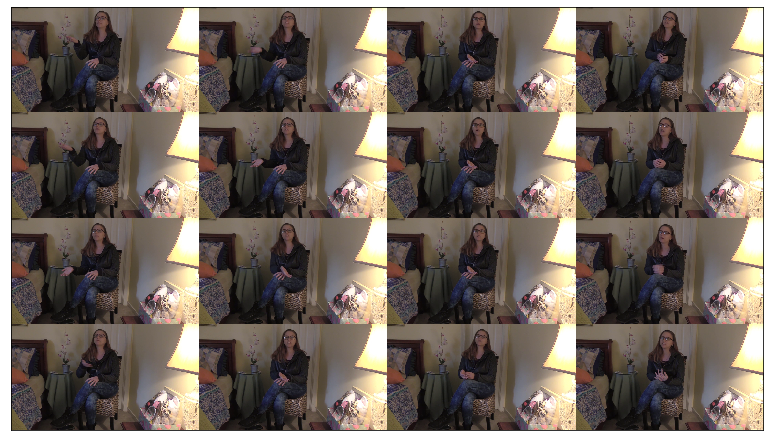

In [121]:
plot_faces(frames[2], figsize=(10.8, 19.2))

In [122]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [123]:
detector = MTCNN(device=device, post_process=False)

In [138]:
def detect_facenet_pytorch(detector, images, batch_size):
    faces = []
    for lb in np.arange(0, len(images), batch_size):
        imgs_pil = [PIL.Image.fromarray(image) for image in images[lb:lb+batch_size]]
        faces.extend(detector(imgs_pil))
    return torch.stack(faces)

In [139]:
%%time 
faces = detect_facenet_pytorch(detector, frames[2][:100], 32)

CPU times: user 31.6 s, sys: 7.37 s, total: 39 s
Wall time: 40 s


In [141]:
faces

torch.Size([100, 3, 160, 160])

In [142]:
faces[0].shape, faces[8].shape

(torch.Size([3, 160, 160]), torch.Size([3, 160, 160]))

In [25]:
%%time
faces = detect_facenet_pytorch(detector, images_540_960, 32)

CPU times: user 1min 35s, sys: 24.2 s, total: 2min
Wall time: 2min 7s


In [151]:
diff = (faces[1:] - faces[:-1]).abs()

In [152]:
diff.shape

torch.Size([99, 3, 160, 160])

In [27]:
diff = [abs(faces[i] - faces[i-1]) for i in range(len(faces))]

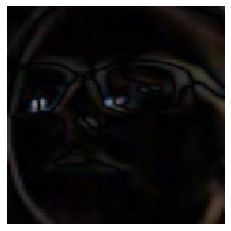

In [166]:
plt.imshow(diff[3].permute(1, 2, 0).int()); plt.axis('off');

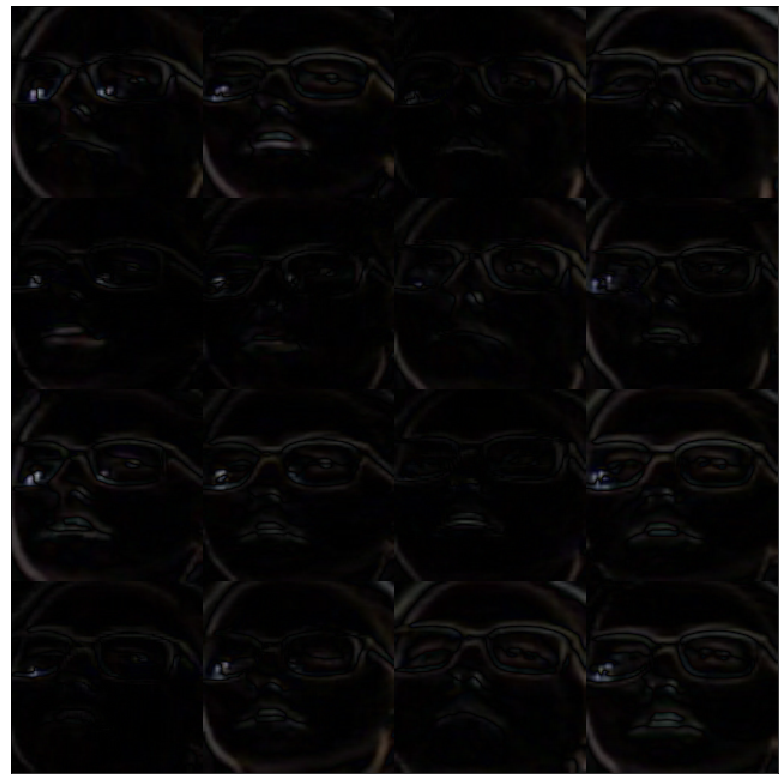

In [165]:
plot_faces(diff.permute(0, 2, 3, 1).int().numpy(), figsize=(11, 20))

### Test with a Fake Video

In [167]:
vid_nbr = 7

In [168]:
s.label[vid_nbr]

'FAKE'

In [169]:
HTML(html_vid(s.fname[vid_nbr]))

In [170]:
frames = video2frames(str(s.fname[vid_nbr]), (1280, 720), (960, 540))

100%|██████████| 300/300 [00:07<00:00, 40.94it/s]


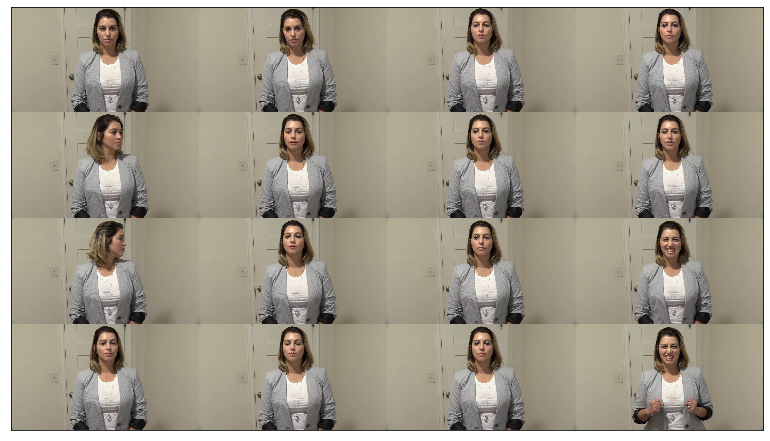

In [171]:
plot_faces(frames[2], figsize=(10.8, 19.2))

In [42]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
detector = MTCNN(device=device, post_process=False)

def detect_facenet_pytorch(detector, images, batch_size):
    faces = []
    for lb in np.arange(0, len(images), batch_size):
        imgs_pil = [Image.fromarray(image) for image in images[lb:lb+batch_size]]
        faces.extend(detector(imgs_pil))
    return faces

times_facenet_pytorch = []

In [43]:
images_540_960.shape

(300, 540, 960, 3)

In [44]:
from PIL import Image

In [172]:
faces = detect_facenet_pytorch(detector, frames[2], 32)

In [45]:
%%time
faces = detect_facenet_pytorch(detector, images_540_960, 32)

CPU times: user 53.3 s, sys: 16.1 s, total: 1min 9s
Wall time: 1min 13s


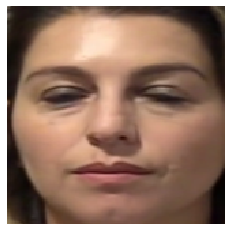

In [175]:
plt.imshow(faces[99].permute(1, 2, 0).int()); plt.axis('off');

In [176]:
diff = (faces[1:] - faces[:-1]).abs()

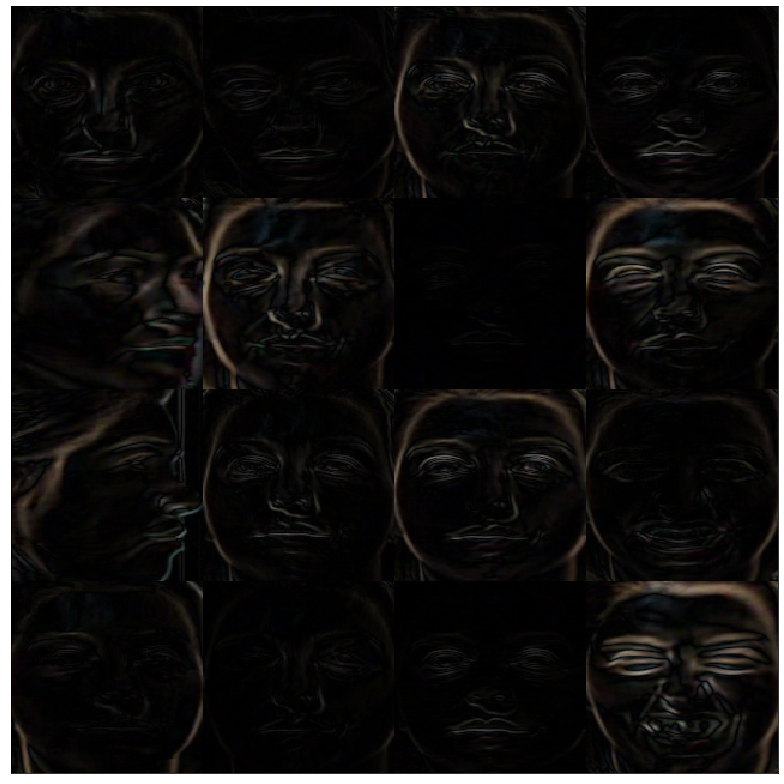

In [177]:
plot_faces(diff.permute(0, 2, 3, 1).int().numpy(), figsize=(11, 20))

# - fin

In [ ]:
from nbdev.export import *

In [ ]:
notebook2script()

Converted 00_lookatdata.ipynb.
Converted 01_face_recog.ipynb.
Converted 02_face_extraction.ipynb.
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
Converted 02bis_Create_Dataset.ipynb.
Converted 03_mesonet.ipynb.
